## Example 1-1. Training and running a linear model using Scikit-Learn

Instead of using the data provided in the book for Cyprus, I took the most recent data from the [Trading Economics website](https://tradingeconomics.com/cyprus/indicators) as of June 5, 2022.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the data
oecd_file = os.path.join("datasets", "lifesat", "oecd_bli_2015.csv")
gdp_file = os.path.join("datasets", "lifesat", "gdp_per_capita.csv")

oecd_bli = pd.read_csv(oecd_file, thousands=',')
gdp_per_capita = pd.read_csv(gdp_file, thousands=',', delimiter='\t', 
                             encoding='latin1', na_values="n/a")

oecd_bli.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


In [2]:
gdp_per_capita.head()

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


In [3]:
# Function to prepare the data (taken from the book's jupyter notebooks)
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli_1 = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli_2 = oecd_bli_1.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita_1 = gdp_per_capita.rename(columns={"2015": "GDP per capita"})
    gdp_per_capita_2 = gdp_per_capita_1.set_index("Country")
    full_country_stats = pd.merge(left=oecd_bli_2, right=gdp_per_capita_2,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[['Air pollution', 'Assault rate', 
                               'Job security', 'Employment rate', 'Life satisfaction',
                               'Water quality', 'Life expectancy', 'GDP per capita']].iloc[keep_indices]

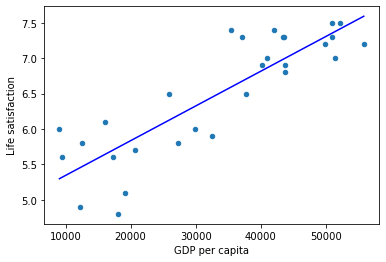

In [5]:
from sklearn.linear_model import LinearRegression

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Select a linear model
lr_1 = LinearRegression()

# Train the model
lr_1.fit(X, y)

# Add the model line to the scatter plot
line_x = np.arange(int(min(X)), int(max(X))).reshape(-1, 1)
line_y = lr_1.predict(line_x)
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.plot(line_x, line_y, color='blue')
plt.show()

In [6]:
# Make a prediction for Cyprus
X_new = [[30438]]
print(lr_1.predict(X_new))

[[6.34802874]]


I will add another feature as a regressor for the linear model.

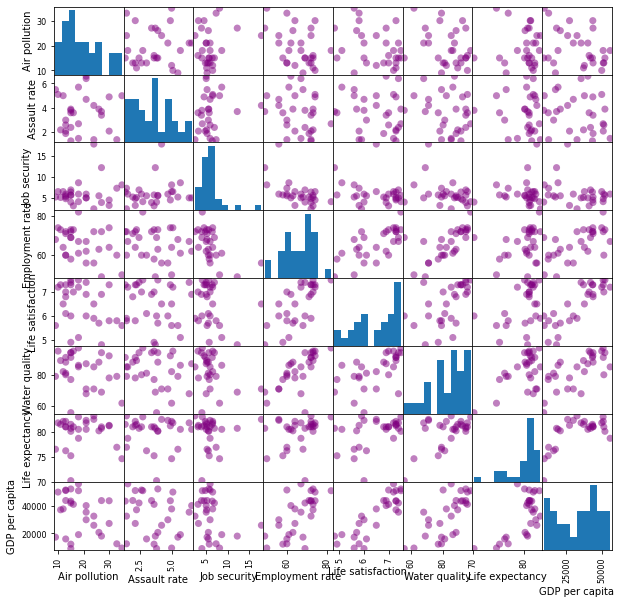

In [7]:
# Pairwise plot between variables
pd.plotting.scatter_matrix(country_stats, s=200, c='purple', figsize=[10, 10])
plt.show()

The next best thing seems to be Employment rate.

In [8]:
# Add the new regressor
X = np.c_[country_stats[["GDP per capita", "Employment rate"]]]

# Train a new model
lr_2 = LinearRegression()
lr_2.fit(X, y)

# Make a new prediction for Cyprus
X_new = [[30438, 72.3]]
print(lr_2.predict(X_new))

[[6.55645999]]


Now, I will attempt to fit a k-Nearest Neighbors regression model using only the GDP per capita as feature to see how close the prediction gets to the linear regression model with 2 variables.

In [9]:
from sklearn.neighbors import KNeighborsRegressor

# Change the features matrix 
X = np.c_[country_stats["GDP per capita"]]

# Replace the linear regression model  with k-Nearest Neighbors regression
knnr = KNeighborsRegressor(n_neighbors=3)
knnr.fit(X, y)

# Make the prediction
X_new = [[30438]]
print(knnr.predict(X_new))

[[5.9]]


The prediction is closer to the model with 1 regressor instead of 2, but still different from both.